In [1]:
%load_ext autoreload
import json
import sys
import pathlib
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import random
from llm import send_prompt, sort_function
from sort import quicksort, heapsort

cp_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/corona_pandemie').rglob('*.ipynb'):
    with open(file) as f:
        cp_data[file.stem.removeprefix('corona_pandemie_')] = json.load(f)

cw_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/corona_warn_app_analyse').rglob('*.ipynb'):
    with open(file) as f:
        cw_data[file.stem.removeprefix('corona_warn_app_analyse_')] = json.load(f)

rp_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/reproduktionszahl').rglob('*.ipynb'):
    with open(file) as f:
        rp_data[file.stem.removeprefix('reproduktionszahl_')] = json.load(f)

wr_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/werbeindustrie').rglob('*.ipynb'):
    with open(file) as f:
        wr_data[file.stem.removeprefix('werbeindustrie_')] = json.load(f)

In [2]:
from copy import deepcopy

def filter_images(data):
    """Sets the image data to None in the output of code cells."""
    for k, v in data.items():
        for cell in v['cells']:
            if cell['cell_type'] == 'code' and 'outputs' in cell:
                for output in cell['outputs']:
                    if 'data' in output and 'image/png' in output['data']:
                        # remove image from data
                        output['data']['image/png'] = None

filter_images(cp_data)
filter_images(cw_data)
filter_images(rp_data)
filter_images(wr_data)

def filter_output_cells(data_array):
    """Removes the output of code cells."""
    data = deepcopy(data_array)
    for k, v in data.items():
        for i, cell in enumerate(v['cells']):
            if cell['cell_type'] == 'code' and 'outputs' in cell:
                #print(cell['outputs'])
                data[k]['cells'][i]['outputs'] = []
    return data

In [15]:
%autoreload 2
from llm import send_prompt, sort_function

def sort_f7(d1, d2):
    systemprompt = """You are provided with two Jupyter notebooks, 'Notebook A' and 'Notebook B,' each containing exercises and their corresponding solutions. Your task is to evaluate which notebook provides the better solutions based on the following criteria: correctness, accuracy, and completeness. A correct solution should provide the intended answer without errors, an accurate solution should be precise and well-reasoned, and a complete solution should contain solutions to all exercises.

After evaluating both notebooks, output ONLY one of the following responses: 'Notebook A' or 'Notebook B.' Do not include any additional text—only return the name of the better notebook."""

    return sort_function(d1, d2, wr_data, systemprompt)

check_idxs = list(wr_data.keys())
random.shuffle(check_idxs)

wr_data_sorted = heapsort(check_idxs, sort_f7)

Error in request: 401 { "statusCode": 401, "message": "Unauthorized. Access token is missing, invalid, audience is incorrect (https://cognitiveservices.azure.com), or have expired." }
Retrying... 1
Error in request: 401 { "statusCode": 401, "message": "Unauthorized. Access token is missing, invalid, audience is incorrect (https://cognitiveservices.azure.com), or have expired." }
Retrying... 2


KeyboardInterrupt: 

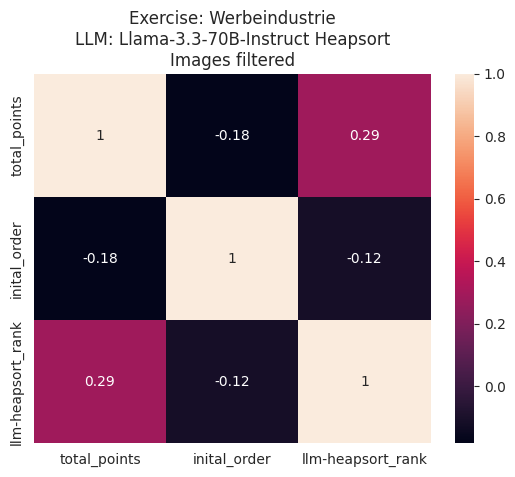

In [17]:
werbeindustrie_points = pd.read_csv('data/shared-dataset/werbeindustrie_points.csv')

df = werbeindustrie_points.loc[:, ['id', 'total_points']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: wr_data_sorted[::1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Werbeindustrie\nLLM: Llama-3.3-70B-Instruct Heapsort\nImages filtered")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [13]:
import os
from azure.ai.inference import ChatCompletionsClient
from azure.core.credentials import AzureKeyCredential
from azure.ai.inference.models import SystemMessage, UserMessage
from dotenv import load_dotenv
load_dotenv()

endpoint = "https://ai-jeyx77fjpq7ebdtm7701ai757489384058.services.ai.azure.com/models" # os.getenv("AZURE_INFERENCE_SDK_ENDPOINT)

model = ChatCompletionsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(os.environ["AZUREAI_ENDPOINT_KEY"]),
    model = "DeepSeek-R1"
)


response = model.complete(
  messages=[
    SystemMessage(content="You are a helpful assistant."),
    UserMessage(content="What are 3 things to visit in Seattle?")
  ],
    model = "DeepSeek-R1",
  max_tokens=1000
)


print(response)

{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "<think>\nOkay, the user is asking for three things to visit in Seattle. Let me start by recalling some of the most popular attractions there. Seattle has a mix of cultural, historical, and natural spots. \n\nFirst, the Space Needle comes to mind. It's an iconic structure and offers great views. Then there's Pike Place Market, which is a bustling market with lots of shops and the original Starbucks. Maybe the Chihuly Garden and Glass nearby would be a good third. Wait, but some might prefer something more nature-oriented, like the Museum of Pop Culture or maybe the waterfront.\n\nWait, the third spot could be the Chihuly Garden since it's near the Space Needle, or maybe the Seattle Waterfront. Alternatively, the Museum of Flight is another option but maybe less central. Or the Olympic Sculpture Park? The user might appreciate a mix of different types of attractions. Let me conf

In [43]:
import os
from azure.ai.inference import ChatCompletionsClient
from azure.core.credentials import AzureKeyCredential
from azure.core.exceptions import HttpResponseError
from azure.ai.inference.models import SystemMessage, UserMessage

from dotenv import load_dotenv
import time
load_dotenv()

endpoint = "https://ai-jeyx77fjpq7ebdtm7701ai757489384058.services.ai.azure.com/models" # os.getenv("AZURE_INFERENCE_SDK_ENDPOINT)

def send_prompt(nb1: str, nb2: str, systemprompt: str = None, max_retries: int = 10) -> dict:
    if not systemprompt:
        systemprompt = """You are provided with two Jupyter notebooks (Notebook A and Notebook B), each containing exercises with their solutions. Evaluate only the correctness and accuracy of the solutions—ignore code style, formatting, documentation, or any other factors. Determine which notebook contains more correct solutions and output ONLY "Notebook A" or "Notebook B"."""

    data = {
        "model": "DeepSeek-R1",  # "Llama-3.3-70B-Instruct"
        "messages": [
            SystemMessage(content=systemprompt),
            UserMessage(content=f"Notebook A: {nb1}\n\n\nNotebook B: {nb2}")
        ],
        "max_tokens": 4096,
        "temperature": 0.1,
    }

    model = ChatCompletionsClient(
        endpoint=endpoint,
        credential=AzureKeyCredential(os.environ["AZUREAI_ENDPOINT_KEY"]),
        model = "DeepSeek-R1"
    )

    for attempt in range(1, max_retries + 1):
        try:
            response = model.complete(
                messages=data["messages"],
                model = data["model"],
                max_tokens=data["max_tokens"],
                temperature=data["temperature"]
            )
        except HttpResponseError as e:
            print(f"Request failed: {e}. Retrying in {2 ** attempt} seconds... (Attempt {attempt}/{max_retries})")
            time.sleep(2 ** attempt)
            continue

        print(f"{response['usage']['prompt_tokens']} + {response['usage']['completion_tokens']}")
        if response and response['choices'][0]['finish_reason'] == 'stop':
            return response

    print("Max retries exceeded due to rate limiting.")
    return None

In [41]:
send_prompt('2aaa', '1aaa')

{'choices': [{'finish_reason': 'stop', 'index': 0, 'message': {'content': '<think>\nOkay, let\'s tackle this problem. The user provided two notebooks, A and B, each with some exercises and solutions. My job is to evaluate which notebook has more correct solutions based solely on correctness and accuracy. I need to ignore code style, formatting, documentation, etc.\n\nFirst, I need to look at the content of each notebook. But wait, the user\'s input shows "Notebook A: 2aaa" and "Notebook B: 1aaa". Hmm, that\'s a bit confusing. The "aaa" part might be a placeholder or a typo. Maybe they meant to indicate the number of correct answers? Like, Notebook A has 2 correct answers and Notebook B has 1? But the user mentioned that each notebook contains exercises with their solutions, so perhaps "2aaa" and "1aaa" are shorthand for the number of correct solutions. For example, "2 correct" and "1 correct".\n\nAlternatively, maybe "aaa" is part of a code or identifier for the exercises. But without 

In [44]:
def sort_function(d1, d2, dataset: dict, systemprompt: str, retry=10) -> bool:
    if retry == 0:
        print("Maximale Anzahl an Versuchen erreicht.")
        return False
    response = send_prompt(str(dataset[d1]), str(dataset[d2]), systemprompt)
    if response:
        if "choices" in response and len(response["choices"]) > 0:
            msg = response["choices"][0]["message"]["content"].strip()
            print(msg)
            if msg.endswith("Notebook A"):
                print(f"{d1} > {d2}")
                return False
            elif msg.endswith("Notebook B"):
                print(f"{d1} < {d2}")
                return True
            else:
                # Implement a retry mechanism here
                if retry > 1:
                    print(f"Antwort nicht eindeutig: {msg}. Retrying... {retry-1}")
                    return sort_function(d1, d2, dataset, systemprompt, retry=retry-1)
                else:
                    print(f"{d1} == {d2}")
                    return False
        else:
            print("Unerwartetes Antwortformat:", response)

    wait_time = 2 ** (10-retry)
    print(f"Retrying... {wait_time}")
    time.sleep(wait_time)
    return sort_function(d1, d2, dataset, systemprompt, retry=retry-1)

def sort_f8(d1, d2):
    systemprompt = """You are provided with two Jupyter notebooks, 'Notebook A' and 'Notebook B,' each containing exercises and their corresponding solutions. Your task is to evaluate which notebook provides the better solutions based on the following criteria: correctness, accuracy, and completeness. A correct solution should provide the intended answer without errors, an accurate solution should be precise and well-reasoned, and a complete solution should contain solutions to all exercises.

After evaluating both notebooks, output ONLY one of the following responses: 'Notebook A' or 'Notebook B.' Do not include any additional text—only return the name of the better notebook."""

    return sort_function(d1, d2, wr_data, systemprompt)

check_idxs = list(wr_data.keys())
random.shuffle(check_idxs)

In [ ]:
wr_data_sorted = heapsort(check_idxs, sort_f8)

2287 + 320
<think>
Okay, let's compare Notebook A and Notebook B based on the criteria given: correctness, accuracy, and completeness.

Starting with **Question 1**, both notebooks provide answers. Notebook A's answer raises two points: the need for data centering and scaling before PCA, and the efficiency of PCA implementation given the high number of data points. These are valid technical points. Notebook B's answer mentions that the center is vague and clusters are more pronounced at the edges. However, this seems more like an observation of the MDS plot rather than a critique of the analysis steps. The question asks for aspects to question in the Data Scientist's approach, so Notebook A's points are more relevant and correct here.

For **Question 2**, Notebook A suggests hierarchical clustering, explaining that it allows specifying cluster proximity via dendrogram cutting and contrasts it with k-means where the number of clusters must be known. This is accurate and complete. Notebo